# Implementation of REINFORCE: Monte-Carlo Policy Gradient Control (episodic) on MountainCar-v0

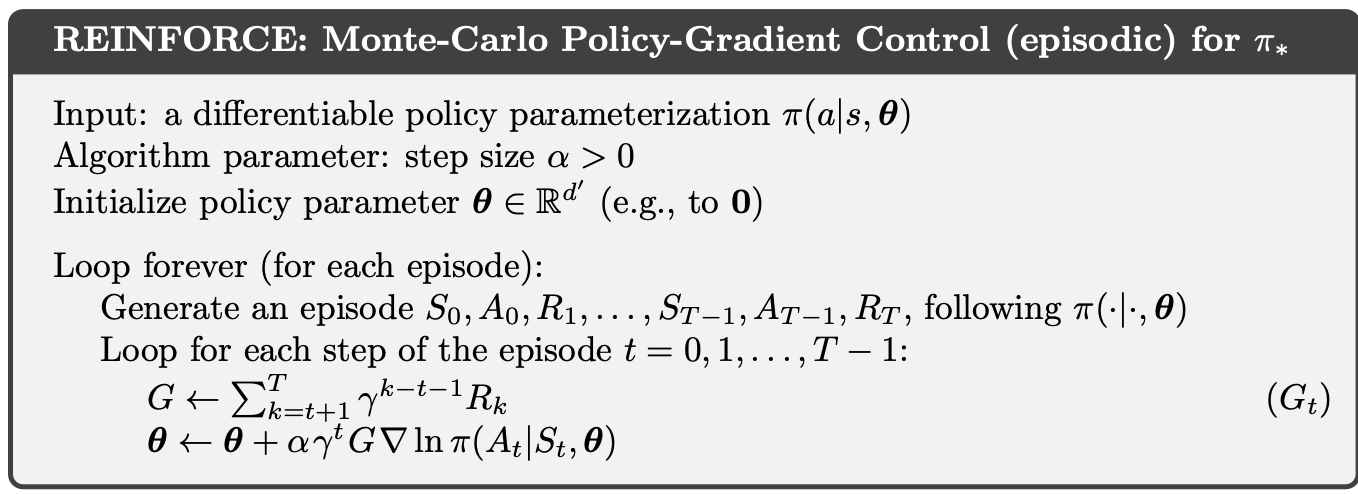



In [5]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [6]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

## Notation of the Code Below
The function names and variables are based off the notation from Sutton.

$x(s,a)$ = Feature Vectors

$h(s,a,\theta)=\theta^Tx(s,a)$


In [7]:
class TileCodingApprox:
    def __init__(self, stateSpaceLowBoundary, stateSpaceHighBoundary, nActions, learningRate):
        assert len(stateSpaceLowBoundary) == len(stateSpaceHighBoundary)
        self._nDimensions = len(stateSpaceLowBoundary)
        self._learningRate = learningRate
        # self._nTilings = nTilings
        # self._scale = self._nTilings / (stateSpaceHighBoundary - stateSpaceLowBoundary)

        # If we want 8 tilings in a 2D Space with 3 actions then the total tiles would be (8+1)*(8+1)*8*3
        # self._totalTiles = ((nTilings + 1)**self._nDimensions) * nTilings * nActions
        self._totalTiles = 4096 # Use 4096 since it appears to be more computationally efficient, not sure why but will do more research on this
        self._nTilings = 16
        self._nTiles = 8
        self._iht = IHT(self._totalTiles)

        self._theta = np.zeros(self._totalTiles*nActions)
        self._theta[0:self._totalTiles] = 1
        self._theta[self._totalTiles*2:] = 1
        
        self._nActions = nActions

        self._minPosition = -1.2
        self._maxPosition = 0.5
        self._minVelocity = -0.07
        self._maxVelocity = 0.07

    def getTiles(self, state):
        position, velocity = state[0], state[1]
        positionScale = self._nTiles / (self._maxPosition - self._minPosition)
        velocityScale = self._nTiles / (self._maxVelocity - self._minVelocity)
        tiles1 = tiles(self._iht, self._nTilings, [position*positionScale, velocity*velocityScale])
        return tiles1

    def x(self, state, action):
        # Constructing the Feature Vector
        # scaledState = np.multiply(self._scale, state)
        activeTiles = self.getTiles(state)
        featureVector = np.zeros(self._totalTiles)
        featureVector[activeTiles] = 1

        featureVectorScaled = np.zeros(self._totalTiles*self._nActions)
        featureVectorScaled[self._totalTiles*action:self._totalTiles*(action+1)] = featureVector
        return featureVectorScaled

    def h(self, state, action): 
        # Calculating the Preference h(s,a,theta)
        preference = np.dot(self._theta, self.x(state, action))
        return preference

    def softmax(self, x):
        # For some reason doing this doesn't work and cause values to become large. Had to utilize this long way 
        # ex = np.exp(x-np.max(x))
        # return ex / np.sum(ex)
        x = np.array(x)
        maxVal = np.max(x)
        x = x - maxVal
        expVal = np.exp(x)
        sumExpVal = np.sum(expVal)
        return expVal / sumExpVal
    
    def policy(self, state):
        hVector = [self.h(state, action) for action in range(self._nActions)]
        policy = self.softmax(hVector)
        return policy
    
    def update(self, state, action, discountedReturn):
        activeFeature = self.x(state, action)
        probVector = self.policy(state)
        expectedFeature = [self.x(state, b) for b in range(self._nActions)]
        expectedFeature = np.dot(probVector, expectedFeature)
        gradient = activeFeature - expectedFeature
        self._theta += self._learningRate * discountedReturn * gradient

## Policy

In [4]:
# Parameters
maxTimeStep = 500
env = gym.make("MountainCar-v0", max_episode_steps=200)
nActions = env.action_space.n 
alpha = 0.001
gamma = 1
maxEpisodes = 10000

# Input
tiles2 = TileCodingApprox(env.observation_space.low, env.observation_space.high, nActions, 1e-8)

rewards = []
# Initialization
for episode in range(maxEpisodes):
    initialState, _ = env.reset()
    initialAction = np.random.choice(nActions, p=tiles2.policy(initialState))

    done = False
    trajectory = []
    totalReward = 0
    currentStepOfEpisode = 0
    while not done:
        nextState, reward, done, _, _ = env.step(initialAction)

        reward += (abs(nextState[1])) # Made is to that the velocity of the current state increases the reward
        trajectory.append([initialState, initialAction, reward])
        totalReward += reward

        initialState = nextState
        initialAction = np.random.choice(nActions, p=tiles2.policy(nextState))

        currentStepOfEpisode += 1
        if currentStepOfEpisode == maxEpisodes:
            done = True
            reward = -maxEpisodes

    rewards.append(totalReward)
    print(totalReward)
    if currentStepOfEpisode != maxEpisodes:
        for t in range(len(trajectory)):
            G = 0
            for k in range(t+1, len(trajectory)):
                G += (gamma**(k-t-1)) * trajectory[k][2]
            tiles2.update(trajectory[t][0],trajectory[t][1],(gamma**t)*G)
        print("DONE # of episode: {}, score: {}".format(episode, totalReward))
    else: 
        print("NOT DONE # of episode: {}, score: {}".format(episode, totalReward))

env.close()

/Users/jasonchen/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


-1714.5979542007635
DONE # of episode: 0, score: -1714.5979542007635
-9754.829378247876
DONE # of episode: 1, score: -9754.829378247876
-9760.905426523628
NOT DONE # of episode: 2, score: -9760.905426523628
-9847.176798355857
NOT DONE # of episode: 3, score: -9847.176798355857
-1889.8586441729258
DONE # of episode: 4, score: -1889.8586441729258
-6540.673546096208
DONE # of episode: 5, score: -6540.673546096208
-7519.256328034311
DONE # of episode: 6, score: -7519.256328034311
-9769.137950392791
NOT DONE # of episode: 7, score: -9769.137950392791
-9802.855297726104
NOT DONE # of episode: 8, score: -9802.855297726104
-6391.294221194087
DONE # of episode: 9, score: -6391.294221194087
-1207.505054416426
DONE # of episode: 10, score: -1207.505054416426
-1068.7114528584207
DONE # of episode: 11, score: -1068.7114528584207
-4153.7341319529105
DONE # of episode: 12, score: -4153.7341319529105
-9776.910481638335
NOT DONE # of episode: 13, score: -9776.910481638335
-9391.140844829488
DONE # of e

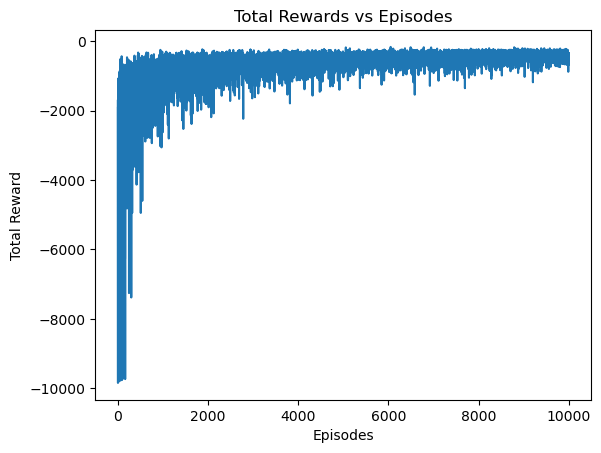

In [9]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Rewards vs Episodes')
plt.show()

## Summary

This algorithm took me a while, however it taught be a lot of stuff. Initially, I was skeptical about the results thinking that I did something wrong with my code. But it wasn't until I did research until I noticed that this result is probably the best you can get utilizing this algorithm on mountain car. A couple of things that I learned are that:
1. The first episode is difficult to learn because the probability of moving left or right is approximately the same. You have to reach the goal once in order to learn.
2. Choosing the step size is difficult because you don't want to overshoot yet you also do not want to undershoot.
3. There has to be a way to modify the weights after each episode instead of when the episode ends.
4. Determining an optimal reward function is difficult. There are tons of literature about this that I want to explore more about in the future. 
5. An issue with this algorithm, similar to all Monte-Carlo algorithms is that there is high variance. One way that minimizes this bias is by implementing a baseline.

There are three main reasons why there is high variance in this:
1. The policy itself which is stochastic
2. The initial distrubtion of the environment
3. Transition dynamics of the environment

The gradient estiamtes from one trajectory deviates from the true gradient. 